In [1]:
from two_class_data_generation import *

import os
import random
import numpy as np
import pandas as pd
import torch
import time
import torchvision
from torchvision import datasets, transforms
from torch import nn, optim
from torch.utils.data import DataLoader, Dataset

import matplotlib.pyplot as plt
import seaborn as sns
%pylab inline
%matplotlib inline
# pd.set_option('display.mpl_style', 'default')
figsize(10, 6)
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

download = False

Populating the interactive namespace from numpy and matplotlib


/Users/ruslanhalitov/opt/anaconda3/lib/python3.8/site-packages/IPython/core/magics/pylab.py:159: UserWarning: pylab import has clobbered these variables: ['random']
`%matplotlib` prevents importing * from pylab and numpy
  warn("pylab import has clobbered these variables: %s"  % clobbered +


In [7]:

def chord_mask(N, base=2, self_loop=True):
    ts = int(round(np.log(N)/np.log(base))) + 1

    if self_loop:
        ch = torch.eye(N, requires_grad=False)
    else:
        ch = torch.zeros(N, requires_grad=False)

    for i in range(N):
        for t in range(ts):
            ch[i, ((i - 1) + base ** t) % N] = 1
    return ch

In [2]:
def weights_init(module):
    classname = module.__class__.__name__
    if classname.find('Linear') != -1:
        torch.nn.init.normal_(module.weight, 0.0, 1e-2)
        if hasattr(module, 'bias') and module.bias is not None:
            torch.nn.init.normal_(module.bias, 0.0, 1e-2)
            
class WModule(nn.Module):
    def __init__(self, n_vec, n_dim, n_hidden):
        super(WModule, self).__init__()
        self.network = nn.Sequential(
            nn.Linear(n_dim, n_hidden),
            nn.GELU(),
            nn.Linear(n_hidden, n_vec)
        )

    def forward(self, data):
        return self.network(data)
    
    
class TWModule(nn.Module):
    def __init__(self, n_vec, n_dim, n_hidden):
        super(TWModule, self).__init__()
        self.network = nn.Sequential(
            nn.Linear(n_dim, n_hidden),
            nn.GELU(),
            nn.Linear(n_hidden, n_vec)
        )

    def forward(self, data):
        return self.network(data).T
    
    
class VIdenticalModule(nn.Module):
    def __init__(self):
        super(VIdenticalModule, self).__init__()

    def forward(self, data):
        return data
    
    
class InteractionModule(nn.Module):
    def __init__(self, n_class, n_W, n_vec, n_dim, n_hidden_f=32, n_hidden_g=10, mask_=True):
        super(InteractionModule, self).__init__()
        self.n_vec = n_vec
        self.n_dim = n_dim
        self.fs = nn.ModuleList(
            [WModule(n_vec, n_dim, n_hidden_f) for i in range(n_W)]
        )
        self.g = VIdenticalModule()
        self.final = nn.Linear(self.n_vec * self.n_dim, n_class, bias=True)
        self.mask_ = mask_

    def forward(self, data):
        V = self.g(data)
        for f in self.fs[::-1]:
            W = f(data)
            if self.mask_:
                W = W * masking
            V = W @ V
        V = self.final(V.view(data.size(0), -1))
        return V


class InteractionModuleSkip(nn.Module):
    def __init__(self, n_class, n_W, n_vec, n_dim, n_hidden_f=32, n_hidden_g=10, residual_every=True, mask_=True):
        super(InteractionModuleSkip, self).__init__()
        self.n_vec = n_vec
        self.n_dim = n_dim
        self.fs = nn.ModuleList(
            [WModule(n_vec, n_dim, n_hidden_f) for i in range(n_W)]
        )
        self.g = VIdenticalModule()
        self.final = nn.Linear(self.n_vec * self.n_dim, n_class, bias=True)
        self.residual_every = residual_every
        self.mask_ = mask_

    def forward(self, data):
        V = self.g(data)
        residual = V
        for f in self.fs[::-1]:
            W = f(data)
            if self.mask_:
                W = W * masking
            V = W @ V
            V += residual
            if self.residual_every:
                residual = V
        V = self.final(V.view(data.size(0), -1))
        return V

In [8]:
class DatasetCreator(Dataset):
    """
    Class to construct a dataset for training/inference
    """

    def __init__(self, mode, data, labels):
        print(f'Creating data loader - {mode}')
        assert mode in ['train', 'test']
        self.data = data
        self.labels = labels
        assert len(self.data) == len(self.labels),\
            "The number of samples doesn't match the number of labels"

    def __getitem__(self, index):
        """
        Returns: tuple (sample, target)
        """
        X = data[index].unsqueeze(-1)
        Y = labels[index].type(torch.LongTensor)
        return (X, Y)

    def __len__(self):
        return len(self.labels)

In [9]:
def TrainSMF(
        net,
        trainloader,
        valloader,
        n_epochs,
        test_freq,
        optimizer,
        loss
):
    losses = []
    losses_eval = []
    accuracies = []
    for epoch in range(n_epochs):
        # Training
        running_loss = 0
        for i, (X, Y) in enumerate(trainloader):
            optimizer.zero_grad()
            pred = net(X)
            output = loss(pred, Y)
            output.backward()
            optimizer.step()
            running_loss += output.item()

        print("Epoch {} - Training loss:   {}".format(epoch, running_loss / len(trainloader)))
        losses.append(float(running_loss / len(trainloader)))
        
        # Validation
        if epoch % test_freq == 0:
            net.eval()
            with torch.no_grad():
                correct = 0
                total = 0
                val_loss = 0.0
                for i, (X, Y) in enumerate(valloader):
                    pred = net(X)
                    val_loss += loss(pred, Y).item()
                    
                    _, predicted = torch.max(pred.data, 1)
                    total += Y.size(0)
                    correct += (predicted == Y).sum().item()
                    
            print("Epoch {} - Validation loss: {}".format(epoch, val_loss / len(valloader)))
            print('Accuracy of the network: %d %%' % (100 * correct / total))
            print('_' * 40)
            losses_eval.append(float(val_loss / len(valloader)))
            accuracies.append(100 * correct / total)
            net.train()
            
    
    fig, axs = plt.subplots(1, 2)
    axs[0].plot([i for i in range(len(losses))], losses, label = "Train")
    axs[0].plot([i for i in range(len(losses_eval))], losses_eval, label = "Validation")
    axs[0].set_xlabel('n_epochs')
    axs[0].set_ylabel('mean_loss')
#     axs[0].set_yscale('log')
    axs[0].legend()
    
    axs[1].plot([i for i in range(len(accuracies))], accuracies)
    axs[1].set_xlabel('n_epochs')
    axs[1].set_ylabel('test accuracy')
#     axs[1].set_yscale('log')
    savefig('./SMF_accuracy.png')

In [10]:
torch.manual_seed(10)
random.seed(10)
np.random.seed(10)

n_data = 2400
n_test = 300
n_class = 2
n_W = 6
n_vec = 64
n_dim = 1
n_hidden_f = 20
n_hidden_g = 3
batch_size = 60

masking = chord_mask(n_vec)

data, labels, data_orig, interaction, mixing = generate_two_class_mixed_data(
    n_data,
    n_vec,
    binary=False,
    same_sigma=False,
    xor=True
)

data, labels, data_val, labels_val = data[n_test:], labels[n_test:], data[:n_test], labels[:n_test]

trainset = DatasetCreator(
    mode='train',
    data = data,
    labels = labels
)
trainloader = torch.utils.data.DataLoader(
    trainset,
    batch_size=batch_size,
    shuffle=True
)


valset = DatasetCreator(
    mode='test',
    data = data_val,
    labels = labels_val
)
valloader = torch.utils.data.DataLoader(
    valset,
    batch_size=batch_size,
    shuffle=True
)

net = InteractionModule(n_class, n_W, n_vec, n_dim, n_hidden_f, n_hidden_g)
net.apply(weights_init)
loss = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=1e-3)

Creating data loader - train
Creating data loader - test


Epoch 0 - Training loss:   0.6920969826834542
Epoch 0 - Validation loss: 0.7136267423629761
Accuracy of the network: 0 %
________________________________________
Epoch 1 - Training loss:   0.6890271527426584
Epoch 1 - Validation loss: 0.7383587956428528
Accuracy of the network: 0 %
________________________________________
Epoch 2 - Training loss:   0.6868835772786822
Epoch 2 - Validation loss: 0.7593080997467041
Accuracy of the network: 0 %
________________________________________
Epoch 3 - Training loss:   0.6854483263833182
Epoch 3 - Validation loss: 0.7768818736076355
Accuracy of the network: 0 %
________________________________________
Epoch 4 - Training loss:   0.6845751575061253
Epoch 4 - Validation loss: 0.7924197316169739
Accuracy of the network: 0 %
________________________________________
Epoch 5 - Training loss:   0.6839422634669713
Epoch 5 - Validation loss: 0.8005421161651611
Accuracy of the network: 0 %
________________________________________
Epoch 6 - Training loss:   0

Epoch 49 - Training loss:   0.017655886969129952
Epoch 49 - Validation loss: 0.0004019341234879903
Accuracy of the network: 100 %
________________________________________


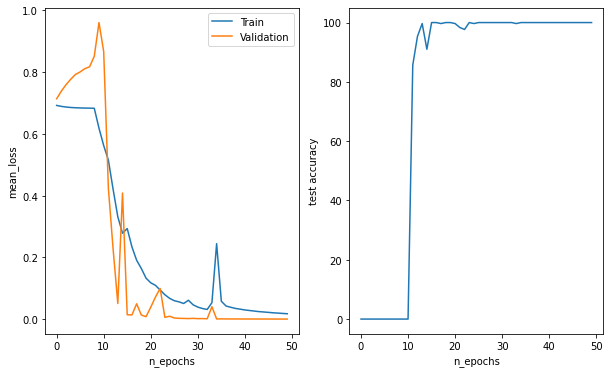

In [11]:
TrainSMF(
    net=net,
    trainloader=trainloader,
    valloader=valloader,
    n_epochs=50,
    test_freq=1,
    optimizer=optimizer,
    loss=loss
)